In [ ]:
import glob
import pandas as pd
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, "src")))
from utils import Utils
from reports import Reports
import matplotlib.pyplot as plt
from overlays import Overlays
from utils import Utils
import numpy as np
import shutil
from tqdm import tqdm

In [2]:
# filter for images with n_fish >= n images
# df_run12_meta_nf = pd.read_csv(r"Z:\__Organized_Directories_InProgress\GobyFinderDatasets\AUV_datasets\runs\run12\run12_metadata.csv", index_col=0, low_memory=False)
all_meta_nf = pd.read_csv(r"Z:\__AdvancedTechnologyBackup\07_Database\MetadataCombined\all_annotated_meta_splits_filtered_20251030.csv", index_col=0, low_memory=False)
df_abs2_meta_nf = all_meta_nf[(all_meta_nf.n_fish >= 0)  & (all_meta_nf.imh > 2176)]
df_abs1_meta_nf = all_meta_nf[(all_meta_nf.n_fish >= 0)  & (all_meta_nf.imh == 2176)]
abiss2_len = len(df_abs2_meta_nf) 
abiss1_len = len(df_abs1_meta_nf)  
# export_paths(df_abs1_meta_nf[df_abs1_meta_nf.split == "test"], run13_folder, subfolder="abiss1_test")
print("usable Abiss1 images:", abiss1_len)
print("usable Abiss2 images:", abiss2_len) #usable Abiss2 images: 14225
few_fish_df = df_abs2_meta_nf[(df_abs2_meta_nf.n_fish < 2)]
new_path = r"Z:\__Organized_Directories_InProgress\GobyFinderDatasets\AUV_datasets\one_fish\images"
output_dir = r"Z:\__Organized_Directories_InProgress\GobyFinderDatasets\AUV_datasets\one_fish\overlays"
# Overlays.plot_label_overlays(few_fish_df.image_path, few_fish_df.label_path, output_dir, overwrite=False)
# usable Abiss1 images: 33356
# usable Abiss2 images: 13549

usable Abiss1 images: 33356
usable Abiss2 images: 13549


In [3]:
def get_tiles_paths_from_batch_dir(BATCH_DIR, BASE_DIR, SPLITS):
    all_tiled_image_paths, all_tiled_label_paths = Utils.get_all_tiled_img_lbl_pths(BASE_DIR, SPLITS)
    batch_tiled_im = os.listdir(BATCH_DIR+"\\"+"images")
    batch_tiled_lb = os.listdir(BATCH_DIR+"\\"+"labels")
    batch_tiled_im_no_ext = list(map(lambda x: x.split(".")[0], batch_tiled_im))
    batch_tiled_lb_no_ext = list(map(lambda x: x.split(".")[0], batch_tiled_lb))

    # --- Refactored & Completed Assignments ---

    # 1. Create basename-to-fullpath dictionaries (The key step for efficient lookup)
    # Note: zip is often cleaner than map(lambda...) for pairing elements.
    img_path_map_no_ext = {os.path.basename(p).split(".")[0]: p for p in all_tiled_image_paths}
    lbl_path_map_no_ext = {os.path.basename(p).split(".")[0]: p for p in all_tiled_label_paths}

    # 2. Use list comprehensions to look up the full paths using the batch basenames
    # This is much faster than searching a list repeatedly.

    batch_tiled_im_fp = [img_path_map_no_ext[bn] for bn in batch_tiled_im_no_ext if bn in img_path_map_no_ext]
    batch_tiled_lb_fp = [lbl_path_map_no_ext[bn] for bn in batch_tiled_lb_no_ext if bn in lbl_path_map_no_ext]

    # --- Verification (Optional) ---
    print(f"Total full paths found for images in batch: {len(batch_tiled_im_fp)}")
    print(f"Total full paths found for labels in batch: {len(batch_tiled_lb_fp)}")
    # assert len(batch_tiled_im_fp) == len(batch_tiled_im), "Some image files not found in the master list."
    # assert len(batch_tiled_lb_fp) == len(batch_tiled_lb), "Some label files not found in the master list."
    return sorted(batch_tiled_im_fp), sorted(batch_tiled_lb_fp)

# BATCH_DIR = r"Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\transects\20240804_001_Iver3069_ABS2\20240804_001_Iver3069_ABS2_batch_00"
# BASE_DIR = r"Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\transects\20240804_001_Iver3069_ABS2"
# batch_tiled_im_fp, batch_tiled_lb_fp = get_tiles_paths_from_batch_dir(BATCH_DIR = BATCH_DIR, BASE_DIR = BASE_DIR, SPLITS = None)

# Utils.write_list_txt(sorted(batch_tiled_im_fp), BATCH_DIR+"\\"+"images.txt")
# Utils.write_list_txt(sorted(batch_tiled_lb_fp), BATCH_DIR+"\\"+"labels.txt")

In [4]:
def get_full_paths_from_tiled_images(tiled_images):
    batch_set = set(map(lambda x: Utils.convert_tile_img_pth_to_basename(x), tiled_images))
    all_full_imgs = glob.glob(r"Z:\__Organized_Directories_InProgress\GobyFinderDatasets\AUV_datasets\full\images\*.png")
    all_full_lbls = glob.glob(r"Z:\__Organized_Directories_InProgress\GobyFinderDatasets\AUV_datasets\full\labels\*.txt")
    print("full images", len(all_full_lbls))
    assert len(all_full_imgs) == len(all_full_lbls)
    img_path_map_no_ext = {os.path.basename(p).split(".")[0]: p for p in all_full_imgs}
    lbl_path_map_no_ext = {os.path.basename(p).split(".")[0]: p for p in all_full_lbls}
    batch_full_im_fp = [img_path_map_no_ext[bn] for bn in batch_set if bn in img_path_map_no_ext]
    batch_full_lb_fp = [lbl_path_map_no_ext[bn] for bn in batch_set if bn in lbl_path_map_no_ext]
    assert len(batch_full_im_fp) == len(batch_full_lb_fp), "number of images and labels do not match"
    print("full image paths from tiled paths", len(batch_full_lb_fp))
    return batch_full_im_fp, batch_full_lb_fp
    
# batch_full_im_fp, batch_full_lb_fp = get_full_paths_from_tiled_images(batch_tiled_im_fp)   
# Utils.write_list_txt(batch_full_im_fp, r"Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\relabel\2025_goby_relabel_batch_01\full\images.txt")
# Utils.write_list_txt(batch_full_lb_fp, r"Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\relabel\2025_goby_relabel_batch_01\full\labels.txt")

In [5]:
def export_batch_paths_tile_relabel(all_images_df):
    """
    Exports full and tiled image/label paths for relabeling batches.
    Prevents resampling and re-exporting of batches that already have an 'images.txt' list.
    """
    # --- Setup ---
    all_tiled_image_paths, all_tiled_label_paths = Utils.get_all_tiled_img_lbl_pths()
    
    # Define constants
    BATCH_SIZE = 100
    innodata_update = r"Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\relabel"
    
    # --- Step 1: Handle the Initial Sample (Pre-existing/Fixed List) ---
    name_initial = "2025_goby_relabel_initial_sample"
    initial_full_dir = os.path.join(innodata_update, name_initial, "full")
    initial_images_list_path = os.path.join(initial_full_dir, "images.txt")

    try:
        initial_images = Utils.read_list_txt(initial_images_list_path)
    except FileNotFoundError:
        print(f"Error: Initial sample list not found at {initial_images_list_path}. Exiting.")
        return # Exit if the baseline list is missing

    # Get basenames of initial sample images
    initial_bn = {os.path.basename(x).split(".")[0] for x in initial_images}
    
    # Remove initial sample images from the pool
    initial_indices = all_images_df[all_images_df.Filename.isin(initial_bn)].index
    remaining_images_df = all_images_df.drop(initial_indices)

    # --- Step 2: Process Subsequent Batches (Repeatable Random Samples) ---
    batch_number = 1
    total_new_batches = 0
    
    while len(remaining_images_df) > 0:
        name = f"2025_goby_relabel_batch_{batch_number:02d}"
        
        # Define paths for the current batch's tiled output
        tile_img_dir = os.path.join(innodata_update, name, "tiled", "images")
        if os.path.exists(tile_img_dir):
            filenames = os.listdir(tile_img_dir)
            tiled_imgs = [f for f in filenames if f.endswith(".png") or f.endswith(".jpg")]
            # Check if the list for this batch already exists (AVOIDS RESAMPLING)
            if len(tiled_imgs) > 0:
                existing_tiled_txt = os.path.join(innodata_update, name, "tiled", "images.txt")
                print(f"Skipping {name}: {len(tiled_imgs)} already exist. Removing images from remaining pool.")
                # integrity check
                Utils.check_txt_file_vs_images(existing_tiled_txt, tile_img_dir)
                # remove its contents from remaining_images_df
                # Find the corresponding full image basenames to drop from the DataFrame
                existing_basenames = list(map(lambda x: Utils.convert_tile_img_pth_to_basename(x), existing_tiled_txt))

                # --- Robust Dropping Logic ---
                # We must use the *full image* names that were sampled to create this batch.
                
                try:
                    sampled_indices = remaining_images_df[
                        remaining_images_df.Filename.isin(existing_basenames)
                    ].index
                    
                    remaining_images_df.drop(sampled_indices, inplace=True)
                    
                except FileNotFoundError:
                    print(f"WARNING: Full list for {name} not found. Could not skip batch.")
                    break # Stop if we can't reliably skip the batch
                # ---------------------------
            
        else:
            # --- Create a New Batch ---
            total_new_batches += 1
            print(f"Creating new batch: {name}")
            
            current_batch_size = min(BATCH_SIZE, len(remaining_images_df))
            
            # Use random_state based on batch number to make the sample repeatable across runs
            # Since the user asked it NOT to change, we must use random_state.
            subset = remaining_images_df.sample(n=current_batch_size, random_state=batch_number)
            
            # Define output paths
            full_dir = os.path.join(innodata_update, name, "full")
            os.makedirs(full_dir, exist_ok=True)
            # Export the current sample batch (Full Images)
            Utils.write_list_txt(subset.image_path.values , os.path.join(full_dir, "images.txt"))
            Utils.write_list_txt(subset.label_path.values , os.path.join(full_dir, "labels.txt"))
            
            # List and Export the Tiled Images for this subset
            tiled_images, tiled_labels = Utils.list_tiled_set(
                subset.Filename.values, all_tiled_image_paths, all_tiled_label_paths
            )
            tile_dir = os.path.join(innodata_update, name, "tiled")
            os.makedirs(tile_dir, exist_ok=True)
            Utils.write_list_txt(tiled_images , os.path.join(tile_dir, "images.txt"))
            Utils.write_list_txt(tiled_labels , os.path.join(tile_dir, "labels.txt"))
            # CRITICAL: Remove the sampled subset from the remaining pool
            remaining_images_df.drop(subset.index, inplace=True)
            
        # Increment the batch counter
        batch_number += 1

    print(f"Total batches checked: {batch_number - 1}")
    print(f"Total NEW batches created: {total_new_batches}")

# all_images_df = df_abs2_meta_nf[(df_abs2_meta_nf.n_fish >= 2)].copy()
# all_images_df.shape
# export_batch_paths_tile_relabel(all_images_df)


# # Copy Batches
# def copy_tiled_relabel_batch(batch = "batch_01"): # Change this to the desired batch number
#     path = f"D:\\ageglio-1\\gobyfinder_yolov8\\datasets\\AUV_datasets\\innodata_updates\\2025_goby_relabel_{batch}\\tiled"
#     images, labels = Utils.read_list_txt(os.path.join(path, "images.txt")), Utils.read_list_txt(os.path.join(path, "labels.txt"))
#     img_folder, lbl_folder = os.path.join(path, "images"), os.path.join(path, "labels")
#     Utils.copy_files_lst(images, img_folder)
#     Utils.copy_files_lst(labels, lbl_folder)

In [6]:
def copy_subsampled_transect_tiled_images_labels_with_objects_for_labeling(collect_id, run_copy=True):
    # assuming the collect_id inference run is stored locally
    all_tiled_image_paths, all_tiled_label_paths = glob.glob(f"..\\output\\inference\\{collect_id}\\tiled\\images\\*.png"), glob.glob(f"..\\output\\inference\\{collect_id}\\tiled\\labels\\*.txt")
    print(len(all_tiled_image_paths), len(all_tiled_label_paths))
    assert len(all_tiled_image_paths) == len(all_tiled_label_paths), "Mismatch between image and label counts."
    full_imgs = Utils.read_list_txt(f"..\\output\\transects\\{collect_id}\\subsampled_images_0.3\\images.txt")
    tiled_images, tiled_labels  = Utils.list_tiled_set(full_imgs, all_tiled_image_paths, all_tiled_label_paths)
    assert len(tiled_images) > 0, "No tiled images found"
    assert len(tiled_images) == len(tiled_labels), "Mismatch between number of images and labels"
    print(f"Number of tiled images from full_imgs: {len(tiled_images)}")
    pd.Series(tiled_images).to_csv(f"..\\output\\inference\\{collect_id}\\tiled\\selected_tiled_images.csv", header=False, index=False)
    pd.Series(tiled_labels).to_csv(f"..\\output\\inference\\{collect_id}\\tiled\\selected_tiled_labels.csv", header=False, index=False)
    # Write the tiled labels to the dataset folder if they are not empty
    innodata_project_folder = f"Z:\\__AdvancedTechnologyBackup\\04_ProjectData\\Innodata_2025\\Goby\\transects\\{collect_id}"
    img_folder = f"{innodata_project_folder}\\images"
    lbl_folder = f"{innodata_project_folder}\\labels"
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)
    if not os.path.exists(lbl_folder):
        os.makedirs(lbl_folder)
    for img, lbl in tqdm(zip(tiled_images, tiled_labels)):
        if os.path.exists(lbl) and os.path.getsize(lbl) > 0:
            shutil.copy2(lbl, lbl_folder)
            shutil.copy2(img, img_folder)
# tranect tiling and preping for labeling
collect_id = "20240618_001_Iver3069_ABS2"
# collect_id = "20240804_001_Iver3069_ABS2"
# copy_subsampled_transect_tiled_images_labels_with_objects_for_labeling(collect_id, run_copy=True)

In [7]:
def export_batch_paths_tile_transect(collect_id):
    """
    Exports tiled image/label paths for transect batches.
    Prevents resampling of transects that already have an export directory.
    Samples by full image basename to ensure all tiles for a full image stay together.
    """
    # Define constants
    BATCH_SIZE = 100
    transect_update = f"Z:\\__AdvancedTechnologyBackup\\04_ProjectData\\Innodata_2025\\Goby\\transects\\{collect_id}"

    # Step 1: Create a DataFrame with ALL existing TILE paths
    # Note: Use os.path.join for robust path construction in glob
    base_dir = os.path.join(transect_update, "images")
    all_image_tiles = glob.glob(os.path.join(base_dir, "*.png"))
    all_label_tiles = glob.glob(os.path.join(transect_update, "labels", "*.txt"))
    
    # Check for empty data before proceeding
    if not all_image_tiles or not all_label_tiles:
        print(f"No tiled data found for {collect_id}. Exiting.")
        return 0

    df = pd.DataFrame(np.c_[all_image_tiles, all_label_tiles], columns=["image_path", "label_path"])
    
    # CRITICAL: Extract the 'Full Image Basename' from the tile label path
    # Assuming tile paths look like 'full_image_name_x000_y000.txt'
    df['basename'] = df.label_path.apply(lambda x: os.path.basename(x).rsplit('_', 2)[0])
    
    # The pool of images to sample from is the UNIQUE full image basenames
    # Use tolist() and convert back to Series later for easier indexing/sampling
    unbatched_basenames_list = df['basename'].unique().tolist()
    unbatched_basenames = pd.Series(unbatched_basenames_list)

    # Now, we proceed with the batching by basename
    batch_number = 0
    total_new_batches = 0
    
    while len(unbatched_basenames) > 0:
        name = f"{collect_id}_batch_{batch_number:02d}"
        transect_path = os.path.join(transect_update, name)
        
        # --- Skipping Logic ---
        images_txt_path = os.path.join(transect_path, "images.txt")
        if os.path.exists(images_txt_path):
            print(f"Skipping existing batch: {name}")
            
            # Read the list of TILED images that were exported
            # Assumes Utils.read_list_txt reads the contents of the file
            exported_tiled_paths = Utils.read_list_txt(images_txt_path)
            
            # Convert the tiled paths back to their full image basenames
            # Assuming Utils.convert_tile_img_pth_to_basename extracts the full image basename
            # e.g., converts 'path/to/img_x000_y000.png' to 'img'
            exported_basenames = {Utils.convert_tile_img_pth_to_basename(x) for x in exported_tiled_paths}

            # Filter the unbatched pool to remove the basenames that are already in this batch
            # Convert Series to list/set for difference, then back to Series for sampling
            remaining_basenames_set = set(unbatched_basenames.tolist()).difference(exported_basenames)
            unbatched_basenames = pd.Series(list(remaining_basenames_set)) # Restore as Series
            
            batch_number += 1
            continue # Go to the next loop iteration (next batch number)
            
        # --- Create a New Batch ---
        else:
            total_new_batches += 1
            print(f"Creating new batch: {name}")
            
            current_batch_size = min(BATCH_SIZE, len(unbatched_basenames))

            # Sample the unique full image basenames from the remaining pool
            # Use random_state=batch_number to make the sample repeatable for this batch number
            # but only if you want repeatability. The prompt said "Do NOT set random_state" 
            # for different random samples, so we'll remove it.
            # Fix: Since unbatched_basenames is a Series of the BASENAMES, sampling works
            # Sample by position (frac=None) since index might be arbitrary
            subset_basenames = unbatched_basenames.sample(
                n=current_batch_size, random_state=None, replace=False
            ) 
            
            # Get ALL tile paths associated with the sampled basenames
            subset_df = df[df['basename'].isin(subset_basenames.tolist())]
            
            # Export the list of TILE paths
            os.makedirs(transect_path, exist_ok=True)
            Utils.write_list_txt(subset_df.image_path.tolist(), os.path.join(transect_path, "images.txt"))
            Utils.write_list_txt(subset_df.label_path.tolist(), os.path.join(transect_path, "labels.txt"))
            
            # CRITICAL: Remove the sampled basenames from the remaining pool for the next iteration
            remaining_basenames_set = set(unbatched_basenames.tolist()).difference(set(subset_basenames.tolist()))
            unbatched_basenames = pd.Series(list(remaining_basenames_set))
            
            # Increment the batch counter
            batch_number += 1

    print(f"Total batches checked: {batch_number}")
    print(f"Total NEW batches created: {total_new_batches}")
    return batch_number

In [8]:
# Transect batches
# collect_id = "20240804_001_Iver3069_ABS2"
collect_id = "20240618_001_Iver3069_ABS2"
n_batches = export_batch_paths_tile_transect(collect_id = collect_id)

Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_00
Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_01
Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_02
Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_03
Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_04
Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_05
Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_06
Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_07
Skipping existing batch: 20240618_001_Iver3069_ABS2_batch_08
Total batches checked: 9
Total NEW batches created: 0


In [14]:
def copy_transect_batch_image_labels(collect_id, batch = 0, copy=False):  # Change this to the desired batch number
    # # Copy Batches
    transect_update = f"Z:\\__AdvancedTechnologyBackup\\04_ProjectData\\Innodata_2025\\Goby\\transects\\{collect_id}"
    path = transect_update + "\\" + f"{collect_id}_batch_{batch:02d}"
    images, labels = Utils.read_list_txt(os.path.join(path, "images.txt")), Utils.read_list_txt(os.path.join(path, "labels.txt"))
    img_folder, lbl_folder = os.path.join(path, "images"), os.path.join(path, "labels")
    if copy:
        Utils.copy_files_lst(images, img_folder)
        Utils.copy_files_lst(labels, lbl_folder)
    Utils.check_txt_file_vs_images(os.path.join(path, "images.txt"), img_folder)

for b in [8]:
    copy_transect_batch_image_labels(collect_id="20240618_001_Iver3069_ABS2", batch = b, copy=True)

--- Checking Batch: Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\transects\20240618_001_Iver3069_ABS2\20240618_001_Iver3069_ABS2_batch_08 (Ignoring Extensions) ---
Integrity Check PASSED: 50 core files match the list.


In [ ]:
# Example Usage:
# To zip a folder named 'my_files' located at 'C:\Users\data\':
# zip_folder("C:\\Users\\data\\my_files") 
# Output: C:\Users\data\my_files.zip (containing the my_files folder)

# Example Usage for the original scenario (hypothetical):
# batch_path = "Z:\\...\\Goby\\transects\\AUV_Run_01\\AUV_Run_01_batch_01"
# zip_folder(os.path.join(batch_path, "images"), "AUV_01_batch_01_images")
# zip_folder(os.path.join(batch_path, "labels"), "AUV_01_batch_01_labels")


# --- Path Construction ---
def get_im_lb_folders(batch, collect_id):
    transect_update = f"Z:\\__AdvancedTechnologyBackup\\04_ProjectData\\Innodata_2025\\Goby\\transects\\{collect_id}"
    batch_name = f"{collect_id}_batch_{batch:02d}"
    path = os.path.join(transect_update, batch_name)
    img_folder = os.path.join(path, "images")
    lbl_folder = os.path.join(path, "labels")
    return img_folder, lbl_folder


# batches = [8]
# collect_id = "20240618_001_Iver3069_ABS2"
# for batch in batches:
#     img_folder, lbl_folder = get_im_lb_folders(batch, collect_id)
#     Utils.zip_folder(img_folder)
#     Utils.zip_folder(lbl_folder)


Zipping content of 'images' into 'Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\transects\20240618_001_Iver3069_ABS2\20240618_001_Iver3069_ABS2_batch_08\images.zip'
Successfully created: Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\transects\20240618_001_Iver3069_ABS2\20240618_001_Iver3069_ABS2_batch_08\images.zip
Zipping content of 'labels' into 'Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\transects\20240618_001_Iver3069_ABS2\20240618_001_Iver3069_ABS2_batch_08\labels.zip'
Successfully created: Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\transects\20240618_001_Iver3069_ABS2\20240618_001_Iver3069_ABS2_batch_08\labels.zip


In [16]:
curve_path_0n = r"..\output\validation\detect\test_sept_1fish\test_run13_1n_curves.csv"
support_0n = df_abs2_meta_nf[(df_abs2_meta_nf.n_fish < 2)].shape[0]
curve_path_2n = r"..\output\validation\detect\test_sept_2-3fish\test_run13_2-3n_curves.csv"
support_2n = df_abs2_meta_nf[(df_abs2_meta_nf.n_fish >= 2) & (df_abs2_meta_nf.n_fish <= 3)].shape[0]
curve_path_4n = r"..\output\validation\detect\test_sept_4fish+\test_run13_4n+_curves.csv"
support_4n = df_abs2_meta_nf[(df_abs2_meta_nf.n_fish >= 4)].shape[0]
curve_path_abs2 = r"..\output\validation\detect\test_sept_abiss2\test_run13_abiss2_curves.csv"
support_abs2 = df_abs2_meta_nf.shape[0]
curve_path_abs1 = r"..\output\validation\detect\test_sept_abiss1\test_run13_abiss1_curves.csv"
support_abs1 = df_abs1_meta_nf.shape[0]
df_0n, fmax_0n, cmax_0n, c_eq_0n, pr_eq_0n = Reports.get_metrics(curve_path_0n) 
df_2n, fmax_2n, cmax_2n, c_eq_2n, pr_eq_2n = Reports.get_metrics(curve_path_2n) 
df_4n, fmax_4n, cmax_4n, c_eq_4n, pr_eq_4n = Reports.get_metrics(curve_path_4n) 
dfabs2, fmaxabs2, cmaxabs2, c_eqabs2, pr_eqabs2 = Reports.get_metrics(curve_path_abs2) 
dfabs1, fmaxabs1, cmaxabs1, c_eqabs1, pr_eqabs1 = Reports.get_metrics(curve_path_abs1) 

The confidence threshold where "precision" and "recall" are the closest is: 0.14915 @ 0.53696
The confidence threshold where "F1" is at its maximum is: 0.16717 @ 0.54382
The confidence threshold where "precision" and "recall" are the closest is: 0.17818 @ 0.7093
The confidence threshold where "F1" is at its maximum is: 0.20921 @ 0.71268
The confidence threshold where "precision" and "recall" are the closest is: 0.13714 @ 0.76145
The confidence threshold where "F1" is at its maximum is: 0.15616 @ 0.76807
The confidence threshold where "precision" and "recall" are the closest is: 0.15115 @ 0.70051
The confidence threshold where "F1" is at its maximum is: 0.18018 @ 0.70597
The confidence threshold where "precision" and "recall" are the closest is: 0.12913 @ 0.83328
The confidence threshold where "F1" is at its maximum is: 0.16416 @ 0.84107


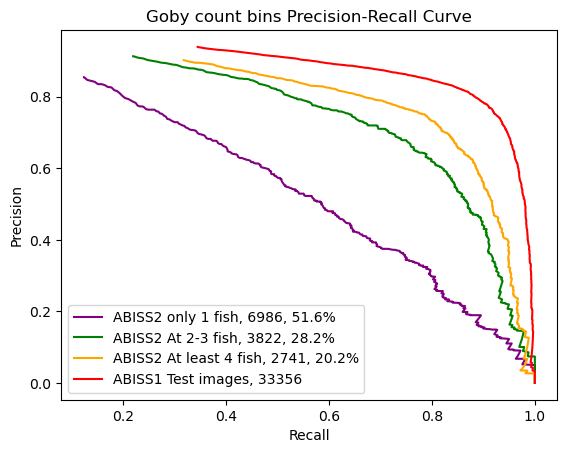

In [28]:
plt.plot(df_0n.precision, df_0n.recall, label=f"ABISS2 only 1 fish, {support_0n}, {support_0n/support_abs2*100:0.1f}%", color="purple")
plt.plot(df_2n.precision, df_2n.recall, label=f"ABISS2 At 2-3 fish, {support_2n}, {support_2n/support_abs2*100:0.1f}%", color="green")
plt.plot(df_4n.precision, df_4n.recall, label=f"ABISS2 At least 4 fish, {support_4n}, {support_4n/support_abs2*100:0.1f}%", color="orange")
plt.plot(dfabs1.precision, dfabs1.recall, label=f"ABISS1 Test images, {support_abs1}", color="red")
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.title('Goby count bins Precision-Recall Curve')
plt.legend() # 1461

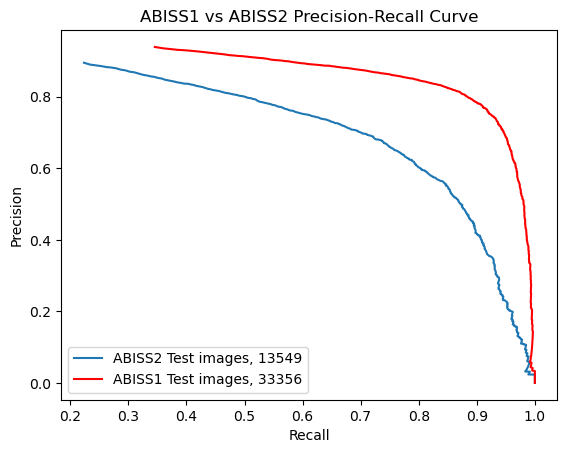

In [29]:
plt.plot(dfabs2.precision, dfabs2.recall, label=f"ABISS2 Test images, {support_abs2}")
plt.plot(dfabs1.precision, dfabs1.recall, label=f"ABISS1 Test images, {support_abs1}", color="red")
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.title('ABISS1 vs ABISS2 Precision-Recall Curve')
plt.legend()

In [20]:
json_files = glob.glob(r"Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\relabel\2025_goby_relabel_initial_sample\full\Innodata Output\Initial Re-Label Full\json\*.json")
image_lst = glob.glob(r"Z:\__AdvancedTechnologyBackup\04_ProjectData\Innodata_2025\Goby\relabel\2025_goby_relabel_initial_sample\full\original\images\images\*.png")
image_path = image_lst[2]
json_path = json_files[2]
Overlays.plot_coco_boxes(image_path, json_path)

An unexpected error occurred: 'images'
